In [2]:
import pandas as pd
import numpy as np

In [3]:
train_df = pd.read_csv('data/processed/train.csv')
test_df = pd.read_csv('data/processed/test.csv')
train_df.shape

(91466, 208)

In [4]:
train_df

,Gender,Age,Driving_License,Previously_Insured,Annual_Premium,Vintage,Response,Region_Code_1,Region_Code_10,Region_Code_11,...,Policy_Sales_Channel_90,Policy_Sales_Channel_91,Policy_Sales_Channel_92,Policy_Sales_Channel_93,Policy_Sales_Channel_94,Policy_Sales_Channel_95,Policy_Sales_Channel_96,Policy_Sales_Channel_97,Policy_Sales_Channel_98,Policy_Sales_Channel_99
0,0,0.169231,1,0,0.000000,0.588235,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.661538,1,1,0.087552,0.941176,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.692308,1,0,0.067415,0.899654,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.030769,1,1,0.053345,0.795848,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.000000,1,1,0.080806,0.332180,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91461,1,0.538462,1,0,0.071361,0.252595,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91462,1,0.123077,1,1,0.000000,0.235294,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91463,0,0.492308,1,0,0.066016,0.608997,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91464,0,0.092308,1,0,0.055758,0.771626,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
from pycaret.classification import *

clf = setup(data = train_df, target = 'Response', 
            log_experiment = True, experiment_name = 'cross-sell', 
            fix_imbalance=True, silent=True, feature_selection=True)

,Description,Value
0,session_id,4570
1,Target,Response
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(91466, 208)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,204
8,Ordinal Features,False
9,High Cardinality Features,False


In [8]:
from sklearn.metrics import log_loss
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target='pred_proba')

Name                                                           LogLoss
Display Name                                                   LogLoss
Score Function                   <function log_loss at 0x7f8f51207790>
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: logloss, dtype: object

In [9]:

top3_models=compare_models(n_select = 3, sort = "logloss", include =['gbc', 'ada', 'lightgbm', 'lr', 'xgboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8325,0.8453,0.4276,0.3536,0.3870,0.2911,0.2929,0.3019,7.9650
lightgbm,Light Gradient Boosting Machine,0.8015,0.8482,0.6194,0.3360,0.4355,0.3277,0.3504,0.3245,2.5840
gbc,Gradient Boosting Classifier,0.7317,0.8464,0.8493,0.2961,0.4391,0.3131,0.3884,0.4185,5.4910
lr,Logistic Regression,0.6997,0.8480,0.9192,0.2814,0.4309,0.2980,0.3945,0.4676,14.8700
ada,Ada Boost Classifier,0.7266,0.8457,0.8620,0.2938,0.4382,0.3111,0.3899,0.6592,3.1730


In [10]:

tuned_top3 = [
  tune_model(
    i,
    optimize="logloss",
    choose_better=True,
    early_stopping=True,
    fold = 5)
  for i in top3_models[0:1]
  ]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
Fold,,,,,,,,
0,0.7951,0.8368,0.5947,0.3222,0.4179,0.3067,0.3279,0.3528
1,0.7961,0.8387,0.5698,0.3185,0.4086,0.2971,0.3155,0.3470
2,0.7948,0.8388,0.5761,0.3179,0.4097,0.2978,0.3171,0.3490
3,0.8024,0.8442,0.5764,0.3294,0.4192,0.3107,0.3283,0.3417
4,0.8016,0.8382,0.5587,0.3247,0.4107,0.3013,0.3174,0.3426
Mean,0.7980,0.8393,0.5751,0.3225,0.4132,0.3027,0.3213,0.3466
Std,0.0033,0.0025,0.0117,0.0042,0.0044,0.0052,0.0056,0.0041


In [11]:
top3_models[0]

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=4570, reg_alpha=0, ...)

In [12]:
tuned_top3[0]

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=4570, reg_alpha=0, ...)

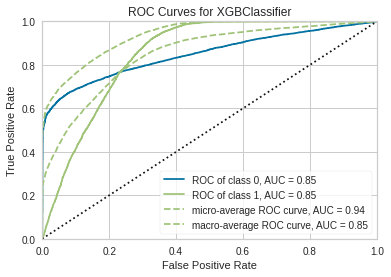

In [13]:
# check the residuals of trained model
plot_model(top3_models[0], 'auc')

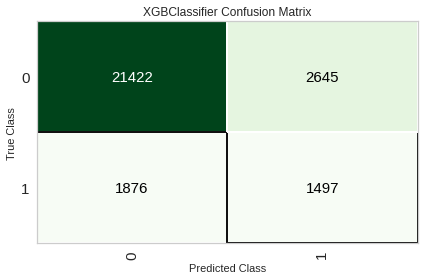

In [14]:
# check feature importance
plot_model(top3_models[0], plot = 'confusion_matrix')

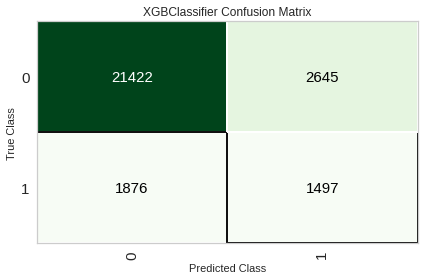

In [15]:
plot_model(tuned_top3[0], plot = 'confusion_matrix')

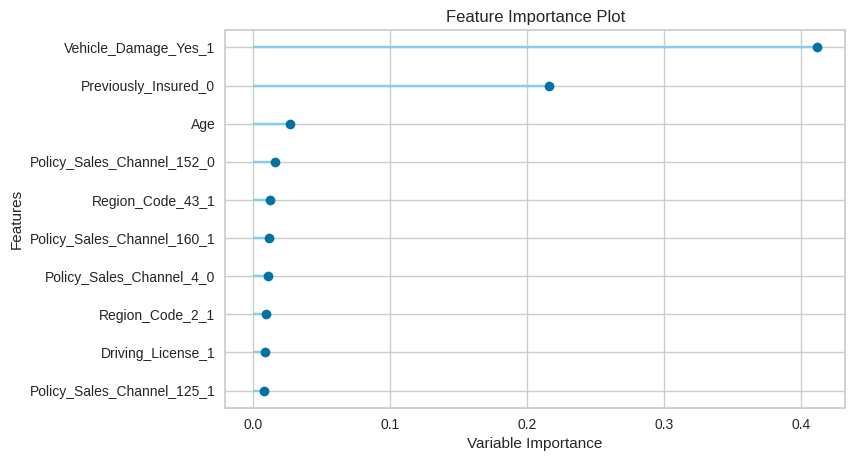

In [16]:
plot_model(top3_models[0], plot = 'feature')

In [17]:
blend_model = blend_models(top3_models, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
Fold,,,,,,,,
0,0.7896,0.8480,0.6616,0.3269,0.4376,0.3260,0.3567,0.3368
1,0.7887,0.8439,0.6450,0.3226,0.4301,0.3176,0.3464,0.3375
2,0.7929,0.8493,0.6753,0.3333,0.4463,0.3365,0.3683,0.3328
3,0.7904,0.8545,0.6843,0.3317,0.4468,0.3362,0.3698,0.3348
4,0.7973,0.8490,0.6332,0.3323,0.4359,0.3266,0.3519,0.3289
Mean,0.7918,0.8489,0.6599,0.3294,0.4393,0.3286,0.3586,0.3342
Std,0.0031,0.0034,0.0188,0.0041,0.0064,0.0071,0.0091,0.0031


In [18]:
# finalize the model
final_best = finalize_model(top3_models[0])
# save model to disk
save_model(final_best, 'model/cross-sale-pipeline')

KeyboardInterrupt: 

In [19]:
result=pull()
result.head()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
Fold,,,,,,,,
0,0.7896,0.8480,0.6616,0.3269,0.4376,0.3260,0.3567,0.3368
1,0.7887,0.8439,0.6450,0.3226,0.4301,0.3176,0.3464,0.3375
2,0.7929,0.8493,0.6753,0.3333,0.4463,0.3365,0.3683,0.3328
3,0.7904,0.8545,0.6843,0.3317,0.4468,0.3362,0.3698,0.3348
4,0.7973,0.8490,0.6332,0.3323,0.4359,0.3266,0.3519,0.3289


In [ ]:
plot_model(final_best, plot = 'confusion_matrix')

NameError: name 'final_best' is not defined

In [22]:
import mlflow
experiment_name='cross-sell'
current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id=current_experiment['experiment_id']
experiment_id

'1'

In [23]:
df = mlflow.search_runs(experiment_id, order_by=["metrics.log_loss DESC"])
best_run_id = df.loc[0,'run_id']
best_run_id

'528dae9178714de58ad4142c7b72f4f9'

In [27]:
X_test = test_df.drop(['Response'], axis=1)
y_test = test_df['Response']

In [29]:
from mlflow import pyfunc
loaded_model = pyfunc.load_model(f'mlruns/{experiment_id}/{best_run_id}/artifacts/model')
y_predict = loaded_model.predict(X_test)

In [30]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(test_df['Response'], y_predict)

array([[16298,  3722],
       [  961,  1886]])